<a href="https://colab.research.google.com/github/Alijgh003/StyleMind-GNN/blob/main/clipGarmentEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=0a31bb3053d2c05fc994b22a0f6631ef44c311c57fe320a33ce00240ec06ef1f
  Stored in directory: /root/.cache/pip/wheels/0d/17/90/042948fd2e2a87f1dcf6db6d438cad015c49db0c53d1d9c7dc
Successfully built openai-clip


In [2]:

!pip install lmdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 22.1 MB/s eta 0:00:00


In [3]:

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import InterpolationMode

import clip

import time
import lmdb
import io

from os import path

In [2]:
datasets_path = path.join("/","content","drive","MyDrive","StyleMind-GNN")
images_path = path.join(datasets_path, "dataset", "polyvore_outfits", "images")
edge_indices_path = path.join(datasets_path, "dataset", "polyvore_outfits", "nondisjoint")
lmdb_path = path.join(datasets_path, "dataset", "polyvore_outfits","my_dataset.lmdb")

In [3]:
import pandas as pd

In [4]:
items_df = pd.read_csv(path.join(datasets_path, "new_items.csv"))
items_df

,Unnamed: 0.1,Unnamed: 0,index,ID,url_name,category_id,semantic_category,fdescription
0,0,0,0,211990161,neck print chiffon plus size,3,tops,neck print chiffon plus size tops
1,1,1,1,183179503,christian pellizzari floral jacquard trousers,2,bottoms,christian pellizzari floral jacquard trousers ...
2,2,2,2,152771755,natures jewelry stainless steel not,11,jewellery,natures jewelry stainless steel not jewellery
3,3,3,3,190445143,balmain women high waist flared,2,bottoms,balmain women high waist flared Decorative gol...
4,4,4,4,211444470,acler orson high waist belted,2,bottoms,acler orson high waist belted This Acler Orson...
...,...,...,...,...,...,...,...,...
251003,251003,251003,251003,108411005,arnica embellished hand painted skirt,2,bottoms,arnica embellished hand painted skirt Shop Ste...
251004,251004,251004,251004,212452593,thom browne little boy knitted,4,outerwear,thom browne little boy knitted outerwear
251005,251005,251005,251005,208651882,colorful vortex print shawl scarf,8,scarves,colorful vortex print shawl scarf scarves
251006,251006,251006,251006,209210426,floral embroidered mesh see thru,3,tops,floral embroidered mesh see thru tops


In [5]:
def build_edge_indices_with_groups(edge_index_tensor_by_groups):
  if(edge_index_tensor_by_groups.shape[0]>0):
    result = torch.cat([edge_index_tensor_by_groups[i] for i in range(edge_index_tensor_by_groups.shape[0])],dim=-1)
    result = result[:,torch.where(result[0]>-1)[0]]
    return result
  else:
    return torch.randn((2, 1))

In [6]:
def build_edge_indices_and_indices_with_groups(edge_index_tensor_by_groups):
  if(edge_index_tensor_by_groups.shape[0]>0):
    edge_indices = torch.cat([edge_index_tensor_by_groups[i] for i in range(edge_index_tensor_by_groups.shape[0])],dim=-1)
    indices = torch.cat([torch.full((edge_index_tensor_by_groups[i].shape[-1],), i) for i in range(edge_index_tensor_by_groups.shape[0])], dim=-1)
    indices = indices[edge_indices[0]>=0].view(-1,1)
    edge_indices = edge_indices[edge_indices>=0].view(2,-1)
    return edge_indices, indices
  else:
    return torch.randn((2, 1)), torch.randn((2,1))

In [7]:
garments = items_df[['index', 'fdescription']].values.tolist()
garments = {i[0]:i[1] for i in garments}
garments

{0: 'neck print chiffon plus size     tops',
 1: "christian pellizzari floral jacquard trousers Gold and black silk blend floral jacquard trousers from Christian Pellizzari. Color: Metallic.  Gender: Female.  Pattern: Floral.  Material: Viscose/Polyester/Silk/Polyamide. Women's Fashion Clothing Pants Christian Pellizzari pants Christian Pellizzari floral jacquard trousers Floral pants Grey pants Print pants Patterned pants Floral-print pants Metallic pants bottoms",
 2: 'natures jewelry stainless steel not     jewellery',
 3: "balmain women high waist flared Decorative gold colored buttons with lion detail . High waisted . Flared hem. Sample size: 36 Women's Fashion Clothing Pants Balmain pants Balmain Women High Waist Flared Knit Pants Balmain Flared pants High-waisted pants Knit pants High rise pants Embellished pants bottoms",
 4: "acler orson high waist belted This Acler Orson High Waist Belted Short features a high waist, foldover detail, and a front self bow tie. Women's Fashion 

In [8]:
train_edge_index = torch.load(path.join(edge_indices_path, "train_edge_index.pth"))
negative_train_edge_index = torch.load(path.join(edge_indices_path,"negative_train_edge_index.pth"))

train_edge_index  = build_edge_indices_with_groups(train_edge_index)
negative_train_edge_index  = build_edge_indices_with_groups(negative_train_edge_index)

test_edge_index = torch.load(path.join(edge_indices_path, "test_edge_index.pth"))
negative_test_edge_index = torch.load(path.join(edge_indices_path, "negative_test_edge_index.pth"))

test_edge_index  = build_edge_indices_with_groups(test_edge_index)
negative_test_edge_index  = build_edge_indices_with_groups(negative_test_edge_index)



valid_edge_index = torch.load(path.join(edge_indices_path, "valid_edge_index.pth"))
negative_valid_edge_index = torch.load(path.join(edge_indices_path, "negative_valid_edge_index.pth"))

valid_edge_index  = build_edge_indices_with_groups(valid_edge_index)
negative_valid_edge_index  = build_edge_indices_with_groups(negative_valid_edge_index)


train_edge_index, negative_train_edge_index, valid_edge_index, negative_valid_edge_index, test_edge_index, negative_test_edge_index

(tensor([[204439, 154376, 154376,  ...,  74651,  74651,  74651],
         [249298, 249298, 204439,  ..., 145194, 153601, 220923]]),
 tensor([[118742, 118742, 100723,  ...,  64782,  64782,  64782],
         [178245, 100723, 178245,  ...,  37821,   4739,  57581]]),
 tensor([[ 67981,  67981,  67981,  ..., 121869, 121869, 121869],
         [221381, 112327,  39445,  ...,  36254,   9839, 118525]]),
 tensor([[102805,  61260, 234578,  ..., 124793, 124793, 122228],
         [176676, 176676, 176676,  ..., 122228, 142856, 142856]]),
 tensor([[121002,  69395,  69395,  ...,  72843, 185573, 185573],
         [238976, 121002, 238976,  ..., 185573,   7277,  99657]]),
 tensor([[ 74755,  63248, 223336,  ..., 211557, 211557, 128858],
         [243442, 243442, 243442,  ..., 128858,  67632,  67632]]))

In [9]:
train_outfits_indices = torch.load(path.join(edge_indices_path, "fill_in_the_blank_train_outfit_indices.pth"))
train_outfits = torch.load(path.join(edge_indices_path, "fill_in_the_blank_train_outfits.pth"))
train_outfits_choices = torch.load(path.join(edge_indices_path, "fill_in_the_blank_train_choices.pth"))
train_outfits, train_outfits_indices,train_outfits_choices

(tensor([114266,  17510,  72727,  ..., 149946,  47046, 171879]),
 tensor([    0,     0,     0,  ..., 53305, 53305, 53305]),
 tensor([[ 76236,  95674, 240960, 192647],
         [235163,  16601, 157829, 101278],
         [144091,  35970, 139786, 187697],
         ...,
         [ 27335,  73880, 225222, 119391],
         [110590, 106928,  78389,   3173],
         [137597,  78533, 171512,  73397]]))

In [10]:
train_edge_index.shape, test_edge_index.shape, valid_edge_index.shape

(torch.Size([2, 686835]), torch.Size([2, 129584]), torch.Size([2, 64922]))

In [11]:
build_edge_indices_and_indices_with_groups(train_edge_index)[:100]

(tensor([[204439, 154376, 154376,  ...,  74651,  74651,  74651],
         [249298, 249298, 204439,  ..., 145194, 153601, 220923]]),
 tensor([[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]]))

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import clip
from torch.utils.data import Dataset, DataLoader

In [13]:
class FusionHead(nn.Module):
    def __init__(self, embed_dim, num_of_layers=1):
        super(FusionHead, self).__init__()
        self.fcs = torch.nn.ModuleList([nn.Linear(2 * embed_dim, embed_dim)] + [nn.Linear(embed_dim, embed_dim) for _ in range(num_of_layers-1)])
        self.bns = torch.nn.ModuleList([nn.BatchNorm1d(embed_dim)] + [nn.BatchNorm1d(embed_dim) for _ in range(num_of_layers-1)])
        self.activation = nn.ReLU()

    def reset_parameters(self):
        for fc in self.fcs:
            fc.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x):
        for fc, bn in zip(self.fcs, self.bns):
            x = self.activation(bn(fc(x)))
        return x

In [17]:
class GarmentDataset(Dataset):
    def __init__(self, data, lmdb_path, transform=None, tokenizer= None):
        self.data = data # dict of (index: garment_description)
        self.env = lmdb.open(lmdb_path, readonly=True, lock=False, readahead=False)
        self.txn = self.env.begin(buffers=True)
        self.length = self._get_length()
        self.transform = transform
        self.tokenizer = tokenizer

    def _get_length(self):
        return len(self.data)

    def __getitem__(self, index):
        if isinstance(index, slice):
            # Handle slicing: return a list of items
            imgs, txts = tuple([l for l in zip(*[self[i] for i in range(*index.indices(len(self)))])])
            return torch.stack(imgs), torch.stack(txts)
        elif isinstance(index, (list)):
            # Handle list or tensor of indices
            imgs, txts = tuple([l for l in zip(*[self[i] for i in index])])
            return torch.stack(imgs), torch.stack(txts)
        elif isinstance(index, torch.Tensor):
            # Handle tensor of indices
            imgs, txts = tuple([l for l in zip(*[self[i] for i in index.tolist()])])
            return torch.stack(imgs), torch.stack(txts)
        else:
            img_bytes = self.txn.get(str(index).encode('ascii'))
            if img_bytes is None:
                raise IndexError(f"Index {index} out of range")
            img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
            if self.transform:
                img = self.transform(img)
            txt = self.data[index]
            if self.tokenizer:
                txt = tokenizer(txt, truncate=True)
            return img, txt

    def __len__(self):
        return self.length

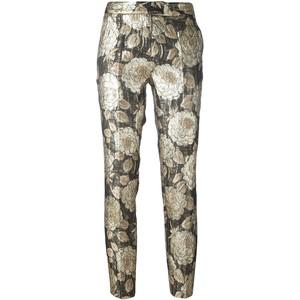

In [18]:
env = lmdb.open(lmdb_path, readonly=True, lock=False, readahead=False)
txn = env.begin(buffers=True)
img_bytes = txn.get(str(1).encode('ascii'))
if img_bytes is None:
    raise IndexError(f"Index {1} out of range")
img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
img

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
import torch
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load BLIP captioning model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda" if torch.cuda.is_available() else "cpu")

# Load your image (replace 'your_image.jpg' with your actual image path)

# Preprocess image
inputs = processor(images=img, return_tensors="pt").to(model.device)

# Generate caption
with torch.no_grad():
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

print("Caption:", caption)

KeyboardInterrupt: 

In [ ]:
def img_to_txt(indices):

    imgs_bytes = [txn.get(str(index).encode('ascii')) for index in indices]

    imgs = [Image.open(io.BytesIO(img_bytes)).convert('RGB') for img_bytes in imgs_bytes]


    # Generate caption


    inputs = processor(images=imgs, return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs)
        captions = processor.batch_decode(outputs, skip_special_tokens=True)
    return captions, imgs

['a pair of black jeans', 'a heart shaped pendant with a red stone', 'a pair of blue sued shoes', 'a brown coat with a collar and a long sleeve']


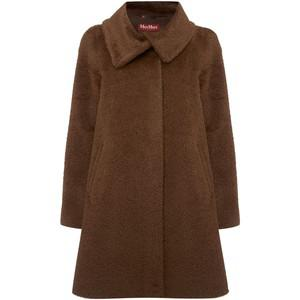

In [ ]:
index = [46,21,32,65984]
cap, imgs = img_to_txt(index)
print(cap)
imgs[-1]

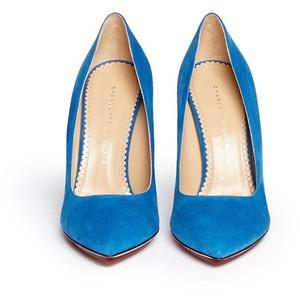

In [ ]:
imgs[-2]

In [ ]:
train_outfits_indices[12:21]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2])

a bag with a newspaper print on it
a pair of silver earrings with a white stone
a black onyx stone and diamond ring
a black and white bracelet with a geometric design
a black blouse with a bow on the front
ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray
a woman in jeans and a white shirt
a building with a balcony and a balcony
a black scarf with a floral design


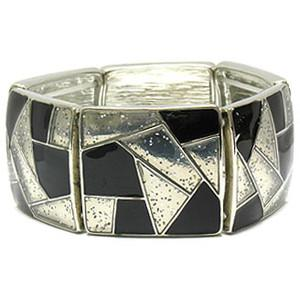

In [ ]:
myoutfit_indices = train_outfits[12:21].tolist()
cap, imgs = img_to_txt(myoutfit_indices)


print('\n'.join(cap))
imgs[3]

In [ ]:
items_df[items_df['index'].isin(myoutfit_indices)]['ID'].tolist()

[2974517,
 2697823,
 366556,
 3445983,
 4689672,
 3436533,
 2779018,
 3756741,
 3655543]

In [ ]:
items_df[items_df['index'].isin(train_outfits_choices[2].tolist())]['ID'].tolist()

[197865263, 141103971, 3905904, 184451588]

a bag with a newspaper print on it
a pair of silver earrings with a white stone
a black onyx stone and diamond ring
a black and white bracelet with a geometric design
a black blouse with a bow on the front
ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray ray
a woman in jeans and a white shirt
a building with a balcony and a balcony
a black scarf with a floral design


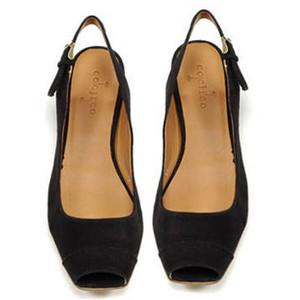

In [ ]:
choice_caps, imgs = img_to_txt(train_outfits_choices[2].tolist())
print('\n'.join(cap))
imgs[0]

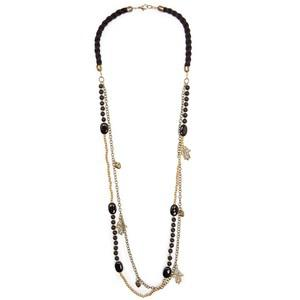

In [ ]:
imgs[3]

In [21]:
class OutfitDataset(Dataset):
    def __init__(self, positive_pairs, negative_pairs):
        #positive_pairs: (idx1, idx2)
        #negative_pairs: (idx1, idx2)
        positive_pairs = [(i[0],i[1], 1) for i in positive_pairs]
        negative_pairs = [(i[0],i[1], 0) for i in negative_pairs]
        self.data = positive_pairs + negative_pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        idx1, idx2, label = self.data[idx]
        return idx1, idx2, label

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.to(torch.float32)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [20]:
for name, param in model.visual.named_parameters():
    if not name.startswith("transformer.resblocks.11"):  # fine-tune only the last block (11 in ViT-B/32)
        param.requires_grad = False

# Freeze text transformer except final block(s)
for name, param in model.transformer.named_parameters():
    if not name.startswith("resblocks.11"):  # fine-tune only the last block (11)
        param.requires_grad = False

# Keep projection heads trainable
model.visual.proj.requires_grad = True
for param in model.token_embedding. parameters():
    param.requires_grad = False
model.text_projection.requires_grad = True

In [21]:
for n, p in model.named_parameters():
    print(n, p.requires_grad, p.dtype)

positional_embedding True torch.float32
text_projection True torch.float32
logit_scale True torch.float32
visual.class_embedding False torch.float32
visual.positional_embedding False torch.float32
visual.proj True torch.float32
visual.conv1.weight False torch.float32
visual.ln_pre.weight False torch.float32
visual.ln_pre.bias False torch.float32
visual.transformer.resblocks.0.attn.in_proj_weight False torch.float32
visual.transformer.resblocks.0.attn.in_proj_bias False torch.float32
visual.transformer.resblocks.0.attn.out_proj.weight False torch.float32
visual.transformer.resblocks.0.attn.out_proj.bias False torch.float32
visual.transformer.resblocks.0.ln_1.weight False torch.float32
visual.transformer.resblocks.0.ln_1.bias False torch.float32
visual.transformer.resblocks.0.mlp.c_fc.weight False torch.float32
visual.transformer.resblocks.0.mlp.c_fc.bias False torch.float32
visual.transformer.resblocks.0.mlp.c_proj.weight False torch.float32
visual.transformer.resblocks.0.mlp.c_proj.bia

In [22]:
tokenizer = clip.tokenize

In [23]:
garment_dataset = GarmentDataset(data=garments, lmdb_path=lmdb_path,
                      transform=preprocess, tokenizer= tokenizer)

In [24]:
len(garment_dataset)

251008

In [25]:
model = model.to(device)

In [35]:
garment_dataloader= DataLoader(garment_dataset, batch_size=256, shuffle=True ,num_workers=2)

In [27]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=1e-4)


In [ ]:
for epoch in range(5):
    model.train()
    total_loss = 0.0

    for i, (imgs, txts) in enumerate(garment_dataloader):
        print(i)
        optimizer.zero_grad()
        imgs, txts = imgs.to(device), txts.to(device)
        image_features = model.encode_image(imgs)
        text_features = model.encode_text(txts.squeeze(1))
        # Normalize
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute logits (image → text)
        logits = (image_features @ text_features.T) * 15
        print("positves", ((logits/15)[torch.arange(logits.shape[0]),torch.arange(logits.shape[0])]).mean())
        print("negatives", (logits/15)[torch.arange(logits.shape[0]),torch.arange(logits.shape[0])-1].mean())
        labels = torch.arange(imgs.shape[0]).to(device)

        loss = torch.nn.functional.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        print(i, loss.item())
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(garment_dataloader):.4f}")

0
positves tensor(0.4467, device='cuda:0', grad_fn=<MeanBackward0>)
negatives tensor(-0.0089, device='cuda:0', grad_fn=<MeanBackward0>)
0 1.9128040075302124
1
positves tensor(0.4558, device='cuda:0', grad_fn=<MeanBackward0>)
negatives tensor(-0.0125, device='cuda:0', grad_fn=<MeanBackward0>)
1 1.8520643711090088
2
positves tensor(0.4545, device='cuda:0', grad_fn=<MeanBackward0>)
negatives tensor(-0.0123, device='cuda:0', grad_fn=<MeanBackward0>)
2 2.0514278411865234
3
positves tensor(0.4534, device='cuda:0', grad_fn=<MeanBackward0>)
negatives tensor(-0.0154, device='cuda:0', grad_fn=<MeanBackward0>)
3 1.9643003940582275
4
positves tensor(0.4609, device='cuda:0', grad_fn=<MeanBackward0>)
negatives tensor(-0.0058, device='cuda:0', grad_fn=<MeanBackward0>)
4 2.0854811668395996
5
positves tensor(0.4692, device='cuda:0', grad_fn=<MeanBackward0>)
negatives tensor(0.0172, device='cuda:0', grad_fn=<MeanBackward0>)
5 2.0918056964874268
6
positves tensor(0.4790, device='cuda:0', grad_fn=<MeanBac

In [32]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
model.eval()
embds = []
with torch.no_grad():
  for i, (imgs, txts) in enumerate(garment_dataloader):
    print(i)
    imgs, txts = imgs.to(device), txts.to(device)
    img_emb = model.encode_image(imgs)
    txt_emb = model.encode_text(txts.squeeze(1))
    embds.append(torch.cat((img_emb, txt_emb), dim=-1))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


TypeError: stack(): argument 'dim' (position 2) must be int, not str

In [ ]:
final_embd = torch.cat(embds)
final_embd.shape

torch.Size([251008, 1024])

In [ ]:
torch.save(final_embd, path.join(datasets_path, "clip_embeddings.pth"))

In [ ]:
positive_train_samples = train_edge_index.T[torch.randperm(train_edge_index.shape[1])[:50000]]
negative_train_samples = negative_train_edge_index.T[torch.randperm(negative_train_edge_index.shape[1])[:50000]]
train_outfit_dataset = OutfitDataset(positive_train_samples, negative_train_samples)

In [ ]:
positive_test_samples = test_edge_index.T[torch.randperm(test_edge_index.shape[1])[:100]]
negative_test_samples = negative_test_edge_index.T[torch.randperm(negative_test_edge_index.shape[1])[:100]]

test_outfit_dataset = OutfitDataset(positive_test_samples, negative_test_samples)

In [ ]:
positive_valid_samples = valid_edge_index.T[torch.randperm(valid_edge_index.shape[1])[:100]]
negative_valid_samples = negative_valid_edge_index.T[torch.randperm(negative_valid_edge_index.shape[1])[:100]]

valid_outfit_dataset = OutfitDataset(positive_valid_samples, negative_valid_samples)

In [ ]:
train_outfit_dataset[10]

In [ ]:
train_outfit_dataloader= DataLoader(train_outfit_dataset, batch_size=2, shuffle=True ,num_workers=2)
test_outfit_dataloader= DataLoader(test_outfit_dataset, batch_size=100, shuffle=True)
valid_outfit_dataloader= DataLoader(valid_outfit_dataset, batch_size=100, shuffle=True)

In [ ]:
fusion_head = FusionHead(embed_dim=model.visual.output_dim).to(device)

In [ ]:
from tqdm import tqdm

In [ ]:
def save_model(model, dst_path):
  torch.save(model.state_dict(), dst_path)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
class GarmentEmbedding(nn.Module):
  def __init__(self, clip_model, fusion_head):
    super(GarmentEmbedding, self).__init__()
    self.clip_model = clip_model
    self.fusion_head = fusion_head


  def forward(self, images, texts):
      image_emb =self.clip_model.encode_image(images)
      text_emb = self.clip_model.encode_text(texts)
      combined = torch.cat([image_emb, text_emb], dim=-1).float()
      emb = self.fusion_head(combined)
      emb = F.normalize(emb, p=2, dim=1)
      return emb

In [ ]:
garment_embedding_model = GarmentEmbedding(model, fusion_head).to(device)

In [ ]:
def test(model, pairs_dataloader, garment_dataset):
    accuracy = 0.0

    model.eval()
    with torch.no_grad():
      for idx1, idx2, labels in pairs_dataloader:
        unique_indices, new_indices = torch.unique(torch.cat((idx1, idx2), dim=-1), return_inverse=True)

        imgs, txts = garment_dataset[unique_indices]

        imgs = imgs.to(device)
        txts = txts.squeeze(1).to(device)

        embeddings = model(imgs, txts)

        emb_a = embeddings[new_indices][:idx1.shape[0]]
        emb_b = embeddings[new_indices][idx1.shape[0]:]

        # Compute loss
        similarities = F.cosine_similarity(emb_a, emb_b,dim=-1)
        corrects = (similarities[labels==1]>=0).sum().float() + (similarities[labels==0]<0).sum().float()
        accuracy = (corrects / emb_a.shape[0]) * 100

    return accuracy

def train(model, pairs_dataloader,  valid_outfit_dataloader, test_outfit_dataloader, garment_dataset, epoch ,loss_fn, optimizer):
    model.train()
    best_valid_acc = 0.0
    epoch_loss= 0.0
    i = 0
    for idx1, idx2, labels in tqdm(pairs_dataloader, desc=f"Epoch {epoch+1}", leave=False):
      optimizer.zero_grad()

      unique_indices, new_indices = torch.unique(torch.cat((idx1, idx2), dim=-1), return_inverse=True)

      imgs, txts = garment_dataset[unique_indices]
      imgs = imgs.to(device)
      txts = txts.squeeze(1).to(device)

      embeddings = model(imgs, txts)

      emb_a = embeddings[new_indices][:idx1.shape[0]]
      emb_b = embeddings[new_indices][idx1.shape[0]:]
      # Compute loss
      targets = (2 * labels - 1).to(device)  # 1 for positive, -1 for negative
      loss = loss_fn(emb_a, emb_b, targets)

      # Optimize
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      i+=1
      if(i%5==0):
        valid_acc = test(garment_embedding_model, valid_outfit_dataloader, garment_dataset)
        test_acc = test(garment_embedding_model, test_outfit_dataloader, garment_dataset)

        if(valid_acc > best_valid_acc):
          save_model(garment_embedding_model, path.join(datasets_path, "garment_embd_clip.pth"))
          best_valid_acc = valid_acc

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss/40:.4f}\n valid_acc={valid_acc} \n test_acc={test_acc}")

    return loss.item()

In [ ]:
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(fusion_head.parameters()),
    lr=1e-5
)
loss_fn = nn.CosineEmbeddingLoss(margin=0.5)


# ====================
# 6. Training Loop
# ====================
num_epochs = 10

for epoch in range(num_epochs):
    epoch_loss = 0.0
    # Wrap the data loader with tqdm and add a description
    epoch_loss = train(garment_embedding_model, train_outfit_dataloader,
                       valid_outfit_dataloader, test_outfit_dataloader, garment_dataset,
                    epoch ,loss_fn, optimizer)


print("Training complete!")

Epoch 1:   0%|          | 1/50000 [00:00<3:38:42,  3.81it/s]

img shape, txt shape torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 77])
torch.Size([4, 3, 224, 224])
torch.Size([4, 77])
torch.Size([4, 512])
torch.Size([4, 512])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
embeddings shape torch.Size([4, 512])
emb_a shape, emb_b shape torch.Size([2, 512]) torch.Size([2, 512])
img shape, txt shape torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 77])
torch.Size([4, 3, 224, 224])
torch.Size([4, 77])
torch.Size([4, 512])
torch.Size([4, 512])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
embeddings shape torch.Size([4, 512])
emb_a shape, emb_b shape torch.Size([2, 512]) torch.Size(

Epoch 1:   0%|          | 4/50000 [00:00<1:50:29,  7.54it/s]

img shape, txt shape torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 77])
torch.Size([4, 3, 224, 224])
torch.Size([4, 77])
torch.Size([4, 512])
torch.Size([4, 512])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
embeddings shape torch.Size([4, 512])
emb_a shape, emb_b shape torch.Size([2, 512]) torch.Size([2, 512])
img shape, txt shape torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 77])
torch.Size([4, 3, 224, 224])
torch.Size([4, 77])
torch.Size([4, 512])
torch.Size([4, 512])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
embeddings shape torch.Size([4, 512])
emb_a shape, emb_b shape torch.Size([2, 512]) torch.Size(

KeyboardInterrupt: 